# Reconstruction depth

Computation of the reconstruction depth and evaluation of this measure as a predictive measure for the robustness of a prediction.

In [1]:
# Libraries and imports
import sys
sys.path.append('../')

import os
import numpy as np
import matplotlib.pyplot as plt
from utils import helpers
import torchvision
import pandas as pd
from PIL import Image
from torchvision.models import resnet50
import torch
import cv2
from spectral_sobol.torch_explainer import WaveletSobol
import scienceplots


2023-04-19 14:42:01.712507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 14:42:02.571812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# folders
imagenet_dir = "../../data/ImageNet/"

# device and model
device = 'cuda:1'
model = resnet50(pretrained = True).to(device)

# parameters
grid_size = 28
batch_size = 128

## Examples

In [3]:
# Set up 
classes = {
 'fox.png': 278,
 'snow_fox.png': 279,
 'polar_bear.png': 296,
 'leopard.png': 288,
 'fox1.jpg': 277,
 'fox2.jpg': 277,
 'sea_turtle.jpg': 33,
 'lynx.jpg': 287,
 'cat.jpg': 281,
 'otter.jpg': 360
}

image_names = list(classes.keys())

images = [Image.open('../assets/{}'.format(img_name)) for img_name in image_names]

# transforms
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

preprocessing = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])
 
x = torch.stack(
    [preprocessing(img) for img in images]
)

y = np.array([classes[img_name] for img_name in image_names])

# compute the explanations
# downs
wavelet = WaveletSobol(model, grid_size = grid_size, nb_design = 8, batch_size = batch_size, opt = {'size' : grid_size})
explanations = wavelet(x,y)

In [4]:
# compute the sets of perturbed images
altered_images = {
    name : helpers.reconstruct_images(image.cpu().permute(1,2,0), cam) for name, image, cam in zip(classes.keys(), x, explanations)
}

# inference on the altered images
altered_inference = {}

for image_name in altered_images.keys():

    images = altered_images[image_name]

    x = torch.stack(
        [preprocessing(img) for img in images]  
    )
    altered_inference[image_name] = {
        'preds' : helpers.evaluate_model_on_samples(x, model, batch_size),
        'label' : classes[image_name]
    }

In [ ]:
# some plots of the altered and reconstructed images

fig, ax = plt.subplots(3,3, figsize = (12,12))
plt.rcParams.update({'font.size': 15})


names = ['fox.png', 'polar_bear.png', 'lynx.jpg']

for i,image_name in enumerate(names):

    # original image (all coefficients)
    ax[i,0].imshow(altered_images[image_name][-1])
    ax[i,0].axis('off')
    ax[i,1].imshow(altered_images[image_name][0])
    ax[i,1].axis('off')
    ax[i,2].imshow(altered_images[image_name][-2])
    ax[i,2].axis('off')

    n_pos = len(altered_images[image_name]) - 2

    if i > 0:
        ax[i,2].set_title('{} coefficients'.format(n_pos))
        ax[i,2].axis('off')

ax[0,0].set_title('Original image')
ax[0,0].axis('off')
ax[0,1].set_title('Higest coefficient')
ax[0,1].axis('off')

n_pos = len(altered_images[names[0]]) - 1
ax[0,2].set_title('Positive coefficients only\n {} coefficients'.format(n_pos))
ax[0,2].axis('off')

plt.suptitle('Reconstruction of images with a subset of Wavelet coefficients')
# plt.savefig('../figs/reconstruction-examples.pdf')
plt.show()

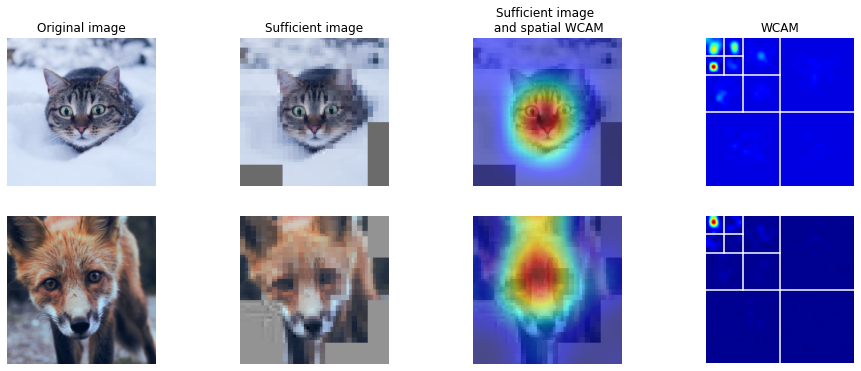

In [7]:
# some plots of the model' predictions for these images

fig, ax = plt.subplots(2,4, figsize = (16,6))

size = 224
levels = 3

# names = ['fox.png', 'polar_bear.png', 'lynx.jpg']
names = ['cat.jpg', 'fox2.jpg']
for i, name in enumerate(names):
    
    preds, label = altered_inference[name]['preds'], altered_inference[name]['label'] 
    depth = np.min(np.where(preds == label * np.ones(len(preds)))[0])
    class_index = list(classes.keys()).index(name)


    # plot the image
    ax[i,0].imshow(altered_images[name][-1])
    ax[i,0].axis('off')

    # plot the minimal correctly predicted image
    ax[i,1].imshow(altered_images[name][depth])
    ax[i,1].axis('off')

    # plot the spatial wcam as overlay
    ax[i,2].imshow(altered_images[name][depth])
    ax[i,2].imshow(wavelet.spatial_cam[class_index], cmap = 'jet', alpha = 0.5)
    ax[i,2].axis('off')

    # plot the wcam
    class_index = list(classes.keys()).index(name)
    wcam = cv2.resize(explanations[class_index], (size, size), interpolation = cv2.INTER_CUBIC)
    ax[i,3].imshow(wcam, cmap = 'jet')
    ax[i,3].axis('off')
    helpers.add_lines(size, levels, ax[i,3])

ax[0,0].set_title('Original image')
ax[0,1].set_title('Sufficient image')
ax[0,2].set_title('Sufficient image \n and spatial WCAM')
ax[0,3].set_title('WCAM')

plt.savefig('../figs/reconstruction-sufficient-2.pdf')
plt.show()


## Reconstruction depth and robustness

We define the reconstruction depth as the number of coefficients necessary to reconstruct an image that is accurately predicted by the model. We wonder whether this metric correlates with the robustness of a prediction. We measure the robustness of the prediction as the ratio between images that are accurately predicted over the total number of perturbation. It encompasses two dimensions: the strenth of the corruption and the type of corruption. 

In [ ]:
# sample images from imagenet
np.random.seed(42)
n_samples = 100

# sample of images
source_img_names = np.random.choice(os.listdir(imagenet_dir), n_samples)

# labels dataframe
labels_true = helpers.format_dataframe(imagenet_dir, source_img_names)

# wavelet explainer
wavelet = WaveletSobol(model, grid_size = grid_size, nb_design = 8, batch_size = batch_size, opt = {'size' : grid_size})

# compute the robustness and reconstruction depth for the set of images
robustness, reconstruction_depth = helpers.compute_robustness_and_depth(source_img_names, imagenet_dir, labels_true, wavelet, model)

In [ ]:
# import matplotlib as mpl # troubleshooting
# mpl.rcParams.update(mpl.rcParamsDefault)

# plots : reconstruction depth v. robustness
plt.style.use(['ieee', 'bright'])
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1,2, figsize = (9,4))

no_nans_source = np.where(~np.isnan(reconstruction_depth['source']))[0]
no_nans_corrupted = np.where(~np.isnan(reconstruction_depth['corrupted']))[0]

ax[0].scatter(robustness, np.array(reconstruction_depth['source']) / 784, label = "Raw values")
ax[1].scatter(robustness, np.array(reconstruction_depth['corrupted']) / 784, label = "Raw values", c = 'red')

# regression lines
m, b = np.polyfit(np.array(robustness)[no_nans_source], np.array(reconstruction_depth['source'])[no_nans_source]  / 784, 1)
ax[0].plot(np.array(robustness), m* np.array(robustness)+b, label = 'Regression line', c = 'black')

# regression lines
m, b = np.polyfit(np.array(robustness)[no_nans_corrupted], np.array(reconstruction_depth['corrupted'])[no_nans_corrupted] / 784, 1)
ax[1].plot(np.array(robustness), m* np.array(robustness)+b, label = 'Regression line', c = 'black')


# titles and plots layouts
plt.suptitle('Correlation between robustness reconstruction depth (RD)')

ax[0].set_xlabel('Robustness to corruptions')
ax[1].set_xlabel('Robustness to corruptions')

ax[0].set_ylabel('Reconstruction depth')
ax[1].set_ylabel('Reconstruction depth')

ax[0].set_title('RD with respect to the source image')
ax[1].set_title('RD with respect to a corrupted image')

ax[0].legend()
ax[1].legend()

# limits
eps = 0.05
x_min, x_max = np.min(robustness) - eps, np.max(robustness) + eps

ax[0].set_xlim(x_min, x_max)
ax[1].set_xlim(x_min, x_max)

y_min = min(np.nanmin(reconstruction_depth['source']), np.nanmin(reconstruction_depth['corrupted'])) / 784 - eps 
y_max = max(np.nanmax(reconstruction_depth['source']), np.nanmax(reconstruction_depth['corrupted'])) / 784 + eps 

ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

plt.legend()
fig.tight_layout()

plt.savefig('../figs/reconstruction-robustness-plot.pdf')
plt.show()